In [185]:
import cv2  
import numpy as np  
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import io
import base64
from pandas import Series
from itertools import product
from itertools import combinations
import itertools
import json
from collections import OrderedDict
from numpyencoder import NumpyEncoder
from skimage.metrics import structural_similarity as ssim
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)
#page_image, x, y, skill_image



class page:
    def __init__(self,page_image):
        self.page_image=page_image

        
        
        
        
        
        
        

def search_image(base,template_arr,thr=0.9): #pil형 이미지 두개 input base이미지에 template 이미지가 있다면 true
        imgray = cv2.cvtColor(np.array(base),cv2.COLOR_BGR2GRAY)
        return_value=-1
        for temp in template_arr:
            template=cv2.cvtColor(np.array(temp),cv2.COLOR_BGR2GRAY)
            w,h = template.shape[::-1]
            res=cv2.matchTemplate(imgray,template,cv2.TM_CCOEFF_NORMED)
            loc = np.where(res>=thr)
            if len(loc[0])==1:
                return_value=template_arr.index(temp)
                break
        return return_value        
        
def skill_check(base,template_arr): #pil형 이미지 두개 input base이미지에 template 이미지가 있다면 true
        imgray = cv2.cvtColor(np.array(base.crop((10,3,30,13))),cv2.COLOR_BGR2GRAY)
        focus=0
        focus_simm=0
        count=0
        sim_arr=[]
        for temp in template_arr:
            template=cv2.cvtColor(np.array(temp),cv2.COLOR_BGR2GRAY)
            sim=ssim(imgray,template)
            sim_arr.append(round(sim,4))
            if sim>focus_simm:
                focus=count
                focus_simm=sim
            count=count+1
        return focus,sim_arr
        
        
        
        
        

def Matching(base_page,target_image='zero_target.png',thr=0.9): #페이지 1차가공 page배열에 강화코어 좌표를 붙여서 리턴
    array_return=[]
    count=0
    template = cv2.imread(target_image,cv2.IMREAD_GRAYSCALE)
    font_count=0
    for i_base in base_page:
        imgray = cv2.cvtColor(np.array(i_base.page_image),cv2.COLOR_BGR2GRAY)
        w,h = template.shape[::-1]
        
        res=cv2.matchTemplate(imgray,template,cv2.TM_CCOEFF_NORMED)
        loc = np.where(res>=thr)
        
        base= cv2.imread(i_base.page_image.filename)
        for pt in zip(*loc[::-1]):
            #cv2.rectangle(base,pt,(pt[0]+w,pt[1]+h),(0,0,255),2)
            cv2.putText(base, str(font_count), pt, cv2.FONT_HERSHEY_DUPLEX, 1,(0,0,155), 2, cv2.LINE_AA)
            font_count=font_count+1
        
        x_min=min(loc[::-1][0])
        x_max=max(loc[::-1][0])
        y_min=min(loc[::-1][1])
        y_max=max(loc[::-1][1])
        #i_base.user_page_image=Image.fromarray(base[x_min-110:x_max-x_min+220,y_min-110:y_max-y_min+220])
        print(x_min-110,x_max-x_min+220,y_min-110,y_max-y_min+220)
        print(x_min,x_max,y_min,y_max)
        i_base.user_page_image=Image.fromarray(base)
        #cv2.imwrite('result_image/result{}.png'.format(count), base)
        base_page[count].x=loc[1]
        base_page[count].y=loc[0]
        count=count+1    
    return base_page











def Skill_cutting(page_arr):#page_arr에 스킬이미지 정보드 붙임
    count=0
    for page in page_arr:
        img_return=[]
        for x,y in zip(page.x,page.y):
            img_return.append(page.page_image.crop((x-10,y-6,x+30,y+44)))
        page_arr[count].skill_image=img_return
        count=count+1
    return page_arr




def skill_classification(job,page_arr): # 'adel', page배열넣기
    left_name = os.listdir(job+"/left/")
    right_name = os.listdir(job+"/right/")
    top_name = os.listdir(job+"/top/")
    level_map = os.listdir("level/")
    left_image=[]
    right_image=[]
    top_image=[]
    level_image=[]
    for i,j,k in zip(left_name,right_name,top_name):
        left_image.append(Image.open(job+"/left/"+i))
        right_image.append(Image.open(job+"/right/"+j))
        top_image.append(Image.open(job+"/top/"+k))
    
    for i in level_map:
        level_image.append(Image.open("level/"+i))

    page_count=0
    for page in page_arr:
        page.skill_kinds=len(os.listdir(job+"/left/"))
        page_arr[page_count].skill_arr=[]
        for skill in page.skill_image:
            tmp=[]
            tmp.append(search_image(skill,left_image))
            tmp.append(search_image(skill,top_image))
            tmp.append(search_image(skill,right_image))
            page_arr[page_count].skill_arr.append(tmp)
        
        fd=open("df_level.txt","a")

        #코어레벨 측정하는 공간!
        page_arr[page_count].skill_level=[]
        for skill in page.skill_image:
            page_arr[page_count].skill_level.append(search_image(skill,level_image,0.99)+1)
            index,index_arr=skill_check(skill,level_image)
            fd.write(str(index_arr)+",\n")
        fd.close()
        page_count=page_count+1



def MakeDF(paged):#중복제외한 강화코어 출력
    df = pd.DataFrame(columns=range(paged[0].skill_kinds+3))
    count=0
    for page in paged:
        skill_count=0
        for skill_label in page.skill_arr:
            tmp=np.zeros(page.skill_kinds+3,dtype=np.int32)
            tmp[skill_label[0]]=1
            tmp[skill_label[1]]=1
            tmp[skill_label[2]]=1
            tmp[-1]=count
            tmp[-2]=skill_label[0]
            tmp[-3]=page.skill_level[skill_count]
            skill_count=skill_count+1
            df.loc[len(df)] = tmp
            count=count+1

    s= df.iloc[:,-3]=df.iloc[:,-3].replace(Series(data=[1,3,4,6,8,10,13,15,19,22,26,30,34,                                              
                                                        39,44,49,55,61,67,74,80,88,95,103,111], index=range(1,26)))
    df.iloc[:,-3]=df.iloc[:,-2].replace(df.groupby(df.iloc[:,-2]).sum().iloc[:,0])
    df=df.drop(df[df.iloc[:,-2]==-1].index)
    df=change_down_level(df)
    s= df.iloc[:,-3]=df.iloc[:,-3].replace(Series(data=range(1,26), index=[1,3,4,6,8,10,13,15,19,22,26,30,34,                                              
                                                        39,44,49,55,61,67,74,80,88,95,103,111]))
    df=df.drop_duplicates(range(paged[0].skill_kinds-1),keep='first')
    df=df.reset_index()
    df=df.drop("index", axis=1)
    return df

def change_down_level(df):
    tmp=df.iloc[:,-3]
    tmpp=[]
    count_arr=[1,3,4,6,8,10,13,15,19,22,26,30,34,39,44,49,55,61,67,74,80,88,95,103,111]
    count_arr= sorted(count_arr,reverse=True)
    for i in tmp:
        for j in count_arr:
            if min(i,j)==i and i!=j:
                continue
            else :
                tmpp.append(j)
                break
    df.iloc[:,-3]=tmpp
    return df
    
def Make_skill_list(df):
    core_arr=[]
    for i in np.unique(df.iloc[:,-2].values):
        a=list(np.array(df[df.iloc[:,-2]==i].iloc[:,-1]))
        if len(a)!=0:
            core_arr.append(a)
    return core_arr
    

    
def Make_combination(df,digit):
    core_arr=Make_skill_list(df)
    qu=[]
    for i in list(combinations(np.array(range(len(core_arr))),min(digit,len(core_arr)))):
        tmp=[]
        for j in i:
            tmp.append(core_arr[j])
        qu.append(list(list(product(*tmp))))
    return list(itertools.chain(*qu))
    
    
def Filter_df(df,essential_skill):
        
    only_3co=df[df.iloc[:,essential_skill][df>0].notnull().sum(axis=1)==3]
    only_2co=df[df.iloc[:,essential_skill][df>0].notnull().sum(axis=1)==2]
    only_2co=only_2co[~only_2co.iloc[:,-2].isin(np.unique(only_3co.iloc[:,-2]))]
    
    return only_2co,only_3co

def trans_combi_list(core_3,core_2):
    tmp=[]
    for i in list(product(*[core_3,core_2])):
        tmp.append(list(i[0])+list(i[1]))
    return tmp

def Make_combi(only_2co,only_3co):
    core_3=Make_combination(only_3co,digit)
    core_2=Make_combination(only_2co,digit-len(core_3[0]))
    return core_2,core_3

def Make_best_combi(combi,df,essential_skill):
    max_score=0
    best_list=[]
    for comb in combi:
        table=df[df.iloc[:,-1].isin(comb)]
        score_arr=table.iloc[:,essential_skill].sum(axis=0)
        score_arr[score_arr[score_arr>2].index]=2
        score=score_arr.sum()
        if max_score<score:
            max_score=score
            best_list=[]
            best_list.append(comb)
        elif max_score==score:
            best_list.append(comb)
    return best_list


def return_core_combi(input_img,job,digit,essential_skill):
    paged= Skill_cutting(Matching(input_img))
    skill_classification(job,paged)
    df = MakeDF(paged)
    only_2co,only_3co=Filter_df(df,essential_skill)
    core_2,core_3 = Make_combi(only_2co,only_3co)
    combi=trans_combi_list(core_3,core_2)
    best_list=Make_best_combi(combi,df,essential_skill)
    return best_list,paged,df

In [186]:
file_name=['cap1.png','cap2.png','cap3.png','cap4.png','cap5.png','cap6.png','cap7.png']
input_img=[]
#file_name=['null.png']
for i in file_name:
    input_img.append(page(Image.open(i)))
#r개발용코드
job='adel'
digit=4
essential_skill=[1,4,6]
#input_img 사용자 이미지 input
#job 직업
#digit 사용 코어칸수
#필수스킬

In [187]:
combi_list,paged,df=return_core_combi(input_img,"job/"+job,digit,essential_skill)
combi_list

-54 275 -63 277
56 111 47 104
122 550 59 562
232 562 169 511
122 550 59 562
232 562 169 511
122 550 59 562
232 562 169 511
122 550 59 562
232 562 169 511
122 550 59 562
232 562 169 511
122 550 59 562
232 562 169 511


[[25, 35, 61, 64],
 [25, 35, 61, 73],
 [25, 35, 61, 78],
 [25, 35, 61, 79],
 [25, 35, 61, 108],
 [25, 35, 64, 79],
 [25, 35, 73, 79],
 [25, 35, 78, 79],
 [25, 35, 64, 108],
 [25, 35, 73, 108],
 [25, 35, 78, 108],
 [25, 35, 79, 108],
 [25, 61, 64, 79],
 [25, 61, 73, 79],
 [25, 61, 78, 79],
 [25, 61, 64, 108],
 [25, 61, 79, 108],
 [25, 64, 79, 108],
 [25, 73, 79, 108],
 [25, 78, 79, 108]]

In [188]:
a=[]
for i in paged:
    a=a+i.skill_arr
a
    

[[-1, -1, -1],
 [-1, -1, -1],
 [0, 9, 7],
 [0, 7, 8],
 [0, 5, 3],
 [0, 3, 2],
 [0, 8, 3],
 [0, 7, 5],
 [0, 7, 2],
 [0, 1, 3],
 [0, 4, 5],
 [0, 8, 6],
 [1, 9, 3],
 [1, 0, 5],
 [1, 7, 3],
 [1, 8, 4],
 [1, 9, 0],
 [1, 9, 4],
 [1, 3, 0],
 [1, 9, 6],
 [1, 4, 9],
 [1, 3, 6],
 [1, 7, 4],
 [1, 0, 6],
 [1, 9, 0],
 [1, 6, 4],
 [1, 8, 3],
 [1, 3, 2],
 [2, 1, 0],
 [2, 0, 6],
 [2, 1, 9],
 [2, 5, 4],
 [2, 3, 0],
 [2, 7, 9],
 [2, 0, 1],
 [2, 1, 6],
 [2, 7, 5],
 [2, 1, 9],
 [2, 6, 9],
 [2, 4, 3],
 [2, 4, 3],
 [2, 0, 6],
 [2, 9, 0],
 [2, 3, 0],
 [2, 5, 9],
 [3, 9, 6],
 [3, 1, 0],
 [3, 9, 8],
 [3, 5, 4],
 [3, 7, 8],
 [3, 8, 1],
 [3, 4, 2],
 [3, 0, 4],
 [3, 7, 5],
 [3, 8, 6],
 [3, 7, 1],
 [3, 6, 1],
 [3, 4, 0],
 [3, 7, 1],
 [3, 9, 7],
 [3, 1, 8],
 [3, 6, 4],
 [3, 7, 5],
 [3, 2, 8],
 [4, 5, 1],
 [4, 1, 8],
 [4, 1, 9],
 [4, 5, 9],
 [4, 2, 5],
 [4, 0, 3],
 [4, 7, 3],
 [4, 3, 7],
 [4, 1, 7],
 [4, 6, 2],
 [4, 1, 8],
 [4, 1, 8],
 [4, 0, 2],
 [4, 1, 5],
 [4, 6, 9],
 [5, 1, 6],
 [5, 3, 9],
 [5, 0, 6],
 [5, 1, 8]

In [189]:
tmp_result=[]
for i in combi_list:
    tmp_list=[]
    for j in i:
        tmp_list.append(a[j])
    tmp_result.append(tmp_list)

tmp_result


[[[1, 6, 4], [2, 1, 6], [3, 6, 4], [4, 5, 1]],
 [[1, 6, 4], [2, 1, 6], [3, 6, 4], [4, 6, 2]],
 [[1, 6, 4], [2, 1, 6], [3, 6, 4], [4, 6, 9]],
 [[1, 6, 4], [2, 1, 6], [3, 6, 4], [5, 1, 6]],
 [[1, 6, 4], [2, 1, 6], [3, 6, 4], [7, 4, 6]],
 [[1, 6, 4], [2, 1, 6], [4, 5, 1], [5, 1, 6]],
 [[1, 6, 4], [2, 1, 6], [4, 6, 2], [5, 1, 6]],
 [[1, 6, 4], [2, 1, 6], [4, 6, 9], [5, 1, 6]],
 [[1, 6, 4], [2, 1, 6], [4, 5, 1], [7, 4, 6]],
 [[1, 6, 4], [2, 1, 6], [4, 6, 2], [7, 4, 6]],
 [[1, 6, 4], [2, 1, 6], [4, 6, 9], [7, 4, 6]],
 [[1, 6, 4], [2, 1, 6], [5, 1, 6], [7, 4, 6]],
 [[1, 6, 4], [3, 6, 4], [4, 5, 1], [5, 1, 6]],
 [[1, 6, 4], [3, 6, 4], [4, 6, 2], [5, 1, 6]],
 [[1, 6, 4], [3, 6, 4], [4, 6, 9], [5, 1, 6]],
 [[1, 6, 4], [3, 6, 4], [4, 5, 1], [7, 4, 6]],
 [[1, 6, 4], [3, 6, 4], [5, 1, 6], [7, 4, 6]],
 [[1, 6, 4], [4, 5, 1], [5, 1, 6], [7, 4, 6]],
 [[1, 6, 4], [4, 6, 2], [5, 1, 6], [7, 4, 6]],
 [[1, 6, 4], [4, 6, 9], [5, 1, 6], [7, 4, 6]]]

In [190]:
skill_level=[0]*paged[0].skill_kinds
skill_level

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [191]:
df_tmp=df.iloc[:,-3:-1].drop_duplicates()
for i,j in zip(df_tmp.iloc[:,-1].values,df_tmp.iloc[:,-2].values):
    skill_level[i]=j

In [192]:
skill_level

[6, 8, 8, 9, 8, 6, 8, 8, 7, 7]

In [193]:
paged[0].skill_image

[<PIL.Image.Image image mode=RGBA size=40x50 at 0x27A97C0A250>,
 <PIL.Image.Image image mode=RGBA size=40x50 at 0x27A97C0A5B0>]

In [194]:
send_json=OrderedDict()
send_json["combi_list"]=combi_list
send_json["skill_arr_detail"]=tmp_result
send_json["skill_level"]=skill_level
json.dumps(send_json, ensure_ascii=False, cls= NumpyEncoder)

'{"combi_list": [[25, 35, 61, 64], [25, 35, 61, 73], [25, 35, 61, 78], [25, 35, 61, 79], [25, 35, 61, 108], [25, 35, 64, 79], [25, 35, 73, 79], [25, 35, 78, 79], [25, 35, 64, 108], [25, 35, 73, 108], [25, 35, 78, 108], [25, 35, 79, 108], [25, 61, 64, 79], [25, 61, 73, 79], [25, 61, 78, 79], [25, 61, 64, 108], [25, 61, 79, 108], [25, 64, 79, 108], [25, 73, 79, 108], [25, 78, 79, 108]], "skill_arr_detail": [[[1, 6, 4], [2, 1, 6], [3, 6, 4], [4, 5, 1]], [[1, 6, 4], [2, 1, 6], [3, 6, 4], [4, 6, 2]], [[1, 6, 4], [2, 1, 6], [3, 6, 4], [4, 6, 9]], [[1, 6, 4], [2, 1, 6], [3, 6, 4], [5, 1, 6]], [[1, 6, 4], [2, 1, 6], [3, 6, 4], [7, 4, 6]], [[1, 6, 4], [2, 1, 6], [4, 5, 1], [5, 1, 6]], [[1, 6, 4], [2, 1, 6], [4, 6, 2], [5, 1, 6]], [[1, 6, 4], [2, 1, 6], [4, 6, 9], [5, 1, 6]], [[1, 6, 4], [2, 1, 6], [4, 5, 1], [7, 4, 6]], [[1, 6, 4], [2, 1, 6], [4, 6, 2], [7, 4, 6]], [[1, 6, 4], [2, 1, 6], [4, 6, 9], [7, 4, 6]], [[1, 6, 4], [2, 1, 6], [5, 1, 6], [7, 4, 6]], [[1, 6, 4], [3, 6, 4], [4, 5, 1], [5, 1

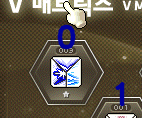

In [195]:
paged[0].user_page_image

In [196]:
# type(paged[0].page_image)

# img_byte_arr = io.BytesIO()
# paged[0].page_image.save(img_byte_arr, format='PNG')
# img_byte_arr = img_byte_arr.getvalue()
# base64.b64encode(img_byte_arr)

In [197]:
level_img=[]
for i in os.listdir("./level"):
    level_img.append(Image.open("level/"+i))
for i in level_img:
    display(i)

In [198]:
for i in paged:
    for j in i.skill_image:
        index,res=skill_check(j,level_img)
        print('{}+":"+{}'.format(index,res))

2+":"+[0.8525, 0.9636, 1.0, 0.8614, 0.9144, 0.8691, 0.8705, 0.9054, 0.9378, 0.6451, 0.6352, 0.7537, 0.7905, 0.6473, 0.705, 0.6566, 0.6535, 0.6921, 0.7248, 0.7042, 0.6941, 0.8093, 0.8447, 0.7064, 0.7617]
0+":"+[1.0, 0.838, 0.8525, 0.7509, 0.8281, 0.8516, 0.9094, 0.8556, 0.8622, 0.6003, 0.7765, 0.616, 0.6301, 0.5248, 0.6078, 0.6299, 0.6837, 0.6323, 0.6384, 0.6672, 0.8383, 0.6829, 0.6963, 0.5946, 0.6746]
0+":"+[1.0, 0.838, 0.8525, 0.7509, 0.8281, 0.8516, 0.9094, 0.8556, 0.8622, 0.6003, 0.7765, 0.616, 0.6301, 0.5248, 0.6078, 0.6299, 0.6837, 0.6323, 0.6384, 0.6672, 0.8383, 0.6829, 0.6963, 0.5946, 0.6746]
0+":"+[1.0, 0.838, 0.8525, 0.7509, 0.8281, 0.8516, 0.9094, 0.8556, 0.8622, 0.6003, 0.7765, 0.616, 0.6301, 0.5248, 0.6078, 0.6299, 0.6837, 0.6323, 0.6384, 0.6672, 0.8383, 0.6829, 0.6963, 0.5946, 0.6746]
0+":"+[1.0, 0.838, 0.8525, 0.7509, 0.8281, 0.8516, 0.9094, 0.8556, 0.8622, 0.6003, 0.7765, 0.616, 0.6301, 0.5248, 0.6078, 0.6299, 0.6837, 0.6323, 0.6384, 0.6672, 0.8383, 0.6829, 0.6963, 0.594